# miniFE
MiniFE is an proxy application for unstructured implicit finite element codes. It is similar to HPCCG and pHPCCG but provides a much more complete vertical covering of the steps in this class of applications. MiniFE also provides support for computation on multicore nodes, including pthreads and Intel Threading Building Blocks (TBB) for homogeneous multicore and CUDA for GPUs. Like HPCCG and pHPCCG, MiniFE is intended to be the "best approximation to an unstructured implicit finite element or finite volume application, but in 8000 lines or fewer."

---
## Parameters
```
Compiler = icpc (ICC) 18.0.1 20171018
Build_Flags = -g -O3 -march=native -qopenmp -restrict -mavx -I. -I../utils -I../fem -DMINIFE_SCALAR=double -DMINIFE_LOCAL_ORDINAL=int -DMINIFE_GLOBAL_ORDINAL=int -DMINIFE_CSR_MATRIX -DMINIFE_RESTRICT=restrict
Run_Parameters = -nx 396 -ny 396 -nz 396 
```

---
## Scaling

In [4]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

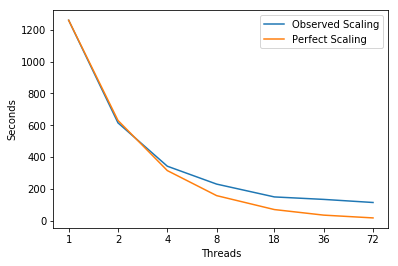

In [5]:
# Plot Measurements
Threads = [1,2,4,8,18,36,72]
fig, ax = plt.subplots(); ax.set_xscale('log', basex=2); ax.set_xticks(Threads)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.plot(Threads,[1260.0, 615.0, 342.5, 230.0, 149.44444444444446, 133.88888888888889, 114.44444444444444],
        label='Observed Scaling')
ax.plot(Threads, [1260.0, 630.0, 315.0, 157.5, 70.0, 35.0, 17.5],
        label='Perfect Scaling')
ax.legend(); ax.set_xlabel('Threads'); ax.set_ylabel('Seconds')
plt.show()

---
## Intel Software Development Emulator
| SDE Metrics | miniFE |
|:-----------|:---:|
| **Arithmetic Intensity** | 0.09 |
| **Bytes per Load Inst** | 7.99 |
| **Bytes per Store Inst** | 9.47 |

---
## Roofline  -  Intel(R) Xeon(R) CPU E5-2699 v3 @ 2.30GHz
### 72 Threads - 36 - Cores 2300.0 Mhz
|     GB/sec     |  L1 B/W |  L2 B/W |  L3 B/W | DRAM B/W |
|:---------------|:-------:|:-------:|:-------:|:--------:|
|**72 Threads**  | 2391.14 |  792.13 | 581.89 |   42.97  |

---
#### Experiment Aggregate Metrics

| CPUTIME % | IPC per Core | Loads per Cycle | L1 Hits per Cycle | |
|:---:|:---:|:---:|:---:|:---:|
| 100% | 0.93 | 0.20 | 0.21 |  |
|**L1 Miss Ratio** | **L2 Miss Ratio** | **L3 Miss Ratio** | **L2 B/W Utilized** | **L3 B/W Utilized** |
| 9.11% | 26.99% | 12.46% | 13.57% | 9.81% |

---
## matvec_std( )
```c++
489 //------------------------------------------------------------------------
490 //Compute matrix vector product y = A*x where:
491 //
492 // A - input matrix
493 // x - input vector
494 // y - result vector
495 //
496 #if defined(MINIFE_CSR_MATRIX)
497 template<typename MatrixType,
498          typename VectorType>
499 struct matvec_std {
500 void operator()(MatrixType& A,
501             VectorType& x,
502             VectorType& y)
503 {
504         exchange_externals(A, x);
505 
506         typedef typename MatrixType::ScalarType ScalarType;
507         typedef typename MatrixType::GlobalOrdinalType GlobalOrdinalType;
508         typedef typename MatrixType::LocalOrdinalType LocalOrdinalType;
509 
510         const MINIFE_GLOBAL_ORDINAL rows_size     = A.rows.size();
511         const LocalOrdinalType* const Arowoffsets = &A.row_offsets[0];
512         const GlobalOrdinalType* const Acols      = &A.packed_cols[0];
513         const ScalarType* const Acoefs            = &A.packed_coefs[0];
514         const ScalarType* const xcoefs __attribute__((aligned(64))) = &x.coefs[0];
515         ScalarType* ycoefs __attribute__((aligned(64))) = &y.coefs[0];
516 
```
#### outline SparseMatrix_functions.hpp:517 (0x410c83)
| CPUTIME % | IPC per Core | Loads per Cycle | L1 Hits per Cycle | |
|:---:|:---:|:---:|:---:|:---:|
| 32.8% | 0.72 | 0.14 | 0.12 |  |
|**L1 Miss Ratio** | **L2 Miss Ratio** | **L3 Miss Ratio** | **L2 B/W Utilized** | **L3 B/W Utilized** |
| *18.41%* | 29.20% | 7.87% | 17.65% | 15.57% |
```c++
517         #pragma omp parallel for
518         for(MINIFE_GLOBAL_ORDINAL row = 0; row < rows_size; ++row) {
519                 const MINIFE_GLOBAL_ORDINAL row_start = Arowoffsets[row];
520                 const MINIFE_GLOBAL_ORDINAL row_end   = Arowoffsets[row+1];
521 
522                 MINIFE_SCALAR sum = 0;
523 
524                 #pragma loop_count(15)
525                 #pragma vector nontemporal
526                 for(MINIFE_GLOBAL_ORDINAL i = row_start; i < row_end; ++i) {
527                         sum += Acoefs[i] * xcoefs[Acols[i]];
528                 }
529 
530                 ycoefs[row] = sum;
531         }
532 }
533 };
```

---
## Daxpby  
### !! Future Investigation : Remove all the if's and just ycoefs[i] = alpha * xcoefs[i] + beta * ycoefs[i] !! Great BR Pred
#### `miniFE::daxpby<miniFE::Vector<double, int, int> >`
| CPUTIME % | IPC per Core | Loads per Cycle | L1 Hits per Cycle | |
|:---:|:---:|:---:|:---:|:---:|
| 6.5% | 0.04 | 0.01 | 0.00 |  |
|**L1 Miss Ratio** | **L2 Miss Ratio** | **L3 Miss Ratio** | **L2 B/W Utilized** | **L3 B/W Utilized** |
| *91.67%* | 22.01% | 11.89% | 9.05% | 8.58% |
```c++
195 template<typename VectorType>
196 void
197   daxpby(const MINIFE_SCALAR alpha,
198         const VectorType& x,
199         const MINIFE_SCALAR beta,
200         VectorType& y)
201 {
202 
203   const MINIFE_LOCAL_ORDINAL n = MINIFE_MIN(x.local_size, y.local_size);
204   const MINIFE_SCALAR* MINIFE_RESTRICT xcoefs __attribute__ ((aligned (64))) = &x.coefs[0];
205         MINIFE_SCALAR* MINIFE_RESTRICT ycoefs __attribute__ ((aligned (64))) = &y.coefs[0];
206 
207   if(alpha == 1.0 && beta == 1.0) {
208           #pragma omp parallel for
209           #pragma vector nontemporal
210           #pragma unroll(8)
211           for(int i = 0; i < n; ++i) {
212             ycoefs[i] += xcoefs[i];
213           }
214   } else if (beta == 1.0) {
215           #pragma omp parallel for
216           #pragma vector nontemporal
217           #pragma unroll(8)
218           for(int i = 0; i < n; ++i) {
219             ycoefs[i] += alpha * xcoefs[i];
220           }
221   } else if (alpha == 1.0) {
222           #pragma omp parallel for
223           #pragma vector nontemporal
224           #pragma unroll(8)
225           for(int i = 0; i < n; ++i) {
226             ycoefs[i] = xcoefs[i] + beta * ycoefs[i];
227           }
228   } else if (beta == 0.0) {
229           #pragma omp parallel for
230           #pragma vector nontemporal
231           #pragma unroll(8)
232           for(int i = 0; i < n; ++i) {
233             ycoefs[i] = alpha * xcoefs[i];
234           }
235   } else {
236           #pragma omp parallel for
237           #pragma vector nontemporal
238           #pragma unroll(8)
239           for(int i = 0; i < n; ++i) {
240             ycoefs[i] = alpha * xcoefs[i] + beta * ycoefs[i];
241           }
242   }
243 
244 }
```

---
## Dot
```c++
246 //-----------------------------------------------------------
247 //Compute the dot product of two vectors where:
248 //
249 // x,y - input vectors
250 //
251 // result - return-value
252 //
253 template<typename Vector>
254 MINIFE_SCALAR dot(const Vector& x,
255       const Vector& y)
256 {
257   const MINIFE_LOCAL_ORDINAL n = x.local_size;
258 
259   typedef typename Vector::ScalarType Scalar;
260   typedef typename TypeTraits<typename Vector::ScalarType>::magnitude_type magnitude;
261 
262   const Scalar* MINIFE_RESTRICT xcoefs __attribute__ ((aligned (64))) = &x.coefs[0];
263   const Scalar* MINIFE_RESTRICT ycoefs __attribute__ ((aligned (64))) = &y.coefs[0];
264 
265   MINIFE_SCALAR result = 0;
266 
```
#### outline Vector_functions.hpp:267 (0x410959)

| CPUTIME % | IPC per Core | Loads per Cycle | L1 Hits per Cycle | |
|:---:|:---:|:---:|:---:|:---:|
| 4.0% | 0.30 | 0.10 | 0.09 |  |
|**L1 Miss Ratio** | **L2 Miss Ratio** | **L3 Miss Ratio** | **L2 B/W Utilized** | **L3 B/W Utilized** |
| 16.46% | 17.97% | 20.45% | 12.35% | 11.22% |
```c++
267   #pragma omp parallel for reduction(+:result)
268   for(int i=0; i<n; ++i) {
269         result += xcoefs[i] * ycoefs[i];
270   }
271 
272 #ifdef HAVE_MPI
273   magnitude local_dot = result, global_dot = 0;
274   MPI_Datatype mpi_dtype = TypeTraits<magnitude>::mpi_type();
275   MPI_Allreduce(&local_dot, &global_dot, 1, mpi_dtype, MPI_SUM, MPI_COMM_WORLD);
276   return global_dot;
277 #else
278   return result;
279 #endif
280 }
```

---
## perform_element_loop
```c++
 46 template<typename GlobalOrdinal,
 47          typename MatrixType, typename VectorType>
 48 void
 49 perform_element_loop(const simple_mesh_description<GlobalOrdinal>& mesh,
 50                      const Box& local_elem_box,
 51                      MatrixType& A, VectorType& b,
 52                      Parameters& /*params*/)
 53 {
 54   typedef typename MatrixType::ScalarType Scalar;
 55 
 56   int global_elems_x = mesh.global_box[0][1];
 57   int global_elems_y = mesh.global_box[1][1];
 58   int global_elems_z = mesh.global_box[2][1];
 59 
 60   //We will iterate the local-element-box (local portion of the mesh), and
 61   //get element-IDs in preparation for later assembling the FE operators
 62   //into the global sparse linear-system.
 63 
 64   GlobalOrdinal num_elems = get_num_ids<GlobalOrdinal>(local_elem_box);
 65   std::vector<GlobalOrdinal> elemIDs(num_elems);
 66 
 67   BoxIterator iter = BoxIterator::begin(local_elem_box);
 68   BoxIterator end  = BoxIterator::end(local_elem_box);
 69 
 70   for(size_t i=0; iter != end; ++iter, ++i) {
 71     elemIDs[i] = get_id<GlobalOrdinal>(global_elems_x, global_elems_y, global_elems_z,
 72                                        iter.x, iter.y, iter.z);
 73   }
 74 
 75   timer_type t_gn = 0, t_ce = 0, t_si = 0;
 76   timer_type t0 = 0;
 77 
 78   const MINIFE_GLOBAL_ORDINAL elemID_size = elemIDs.size();
 79 
 ```
 #### outline perform_element_loop.hpp:80 (0x41d552)

| CPUTIME % | IPC per Core | Loads per Cycle | L1 Hits per Cycle | |
|:---:|:---:|:---:|:---:|:---:|
| 4.8% | 2.20 | 0.34 | 0.43 |  |
|**L1 Miss Ratio** | **L2 Miss Ratio** | **L3 Miss Ratio** | **L2 B/W Utilized** | **L3 B/W Utilized** |
| 1.58% | 24.78% | 22.97% | 5.93% | 3.24% |
 ```c++
 80   #pragma omp parallel for shared (elemIDs)
 81   for(MINIFE_GLOBAL_ORDINAL i=0; i < elemID_size; ++i) {
 82     ElemData<GlobalOrdinal,Scalar> elem_data;
 83     compute_gradient_values(elem_data.grad_vals);
 84 
 85     get_elem_nodes_and_coords(mesh, elemIDs[i], elem_data);
 86     compute_element_matrix_and_vector(elem_data);
 87     sum_into_global_linear_system(elem_data, A, b);
 88   }
 89 
 90 //std::cout << std::endl<<"get-nodes: " << t_gn << std::endl;
 91 //std::cout << "compute-elems: " << t_ce << std::endl;
 92 //std::cout << "sum-in: " << t_si << std::endl;
 93 }
 94 
```

## Impose_dirichlet

```c++
431 //------------------------------------------------------------------------
432 template<typename MatrixType,
433          typename VectorType>
434 void
435 impose_dirichlet(typename MatrixType::ScalarType prescribed_value,
436                     MatrixType& A,
437                     VectorType& b,
438                     int global_nx,
439                     int global_ny,
440                     int global_nz,
441                     const std::set<typename MatrixType::GlobalOrdinalType>& bc_rows)
442 {
443   typedef typename MatrixType::GlobalOrdinalType GlobalOrdinal;
444   typedef typename MatrixType::LocalOrdinalType LocalOrdinal;
445   typedef typename MatrixType::ScalarType Scalar;
446 
447   GlobalOrdinal first_local_row = A.rows.size()>0 ? A.rows[0] : 0;
448   GlobalOrdinal last_local_row  = A.rows.size()>0 ? A.rows[A.rows.size()-1] : -1;
449 
450   typename std::set<GlobalOrdinal>::const_iterator
451     bc_iter = bc_rows.begin(), bc_end = bc_rows.end();
452   for(; bc_iter!=bc_end; ++bc_iter) {
453     GlobalOrdinal row = *bc_iter;
454     if (row >= first_local_row && row <= last_local_row) {
455       size_t local_row = row - first_local_row;
456       b.coefs[local_row] = prescribed_value;
457       zero_row_and_put_1_on_diagonal(A, row);
458     }
459   }
460 
461   const int ROW_COUNT = A.rows.size();
462 
```
#### outline SparseMatrix_functions.hpp:463 (0x40bde9)

| CPUTIME % | IPC per Core | Loads per Cycle | L1 Hits per Cycle | |
|:---:|:---:|:---:|:---:|:---:|
| 5.8% | 1.03 | 0.23 | 0.18 |  |
|**L1 Miss Ratio** | **L2 Miss Ratio** | **L3 Miss Ratio** | **L2 B/W Utilized** | **L3 B/W Utilized** |
| 22.22% | 27.85% | 25.03% | 32.07% | 1.12% |
```c++
463   #pragma omp parallel for
464   for(MINIFE_GLOBAL_ORDINAL i=0; i < ROW_COUNT; ++i) {
465     GlobalOrdinal row = A.rows[i];
466 
467     if (bc_rows.find(row) != bc_rows.end()) continue;
468 
469     size_t row_length = 0;
470     GlobalOrdinal* cols = NULL;
471     Scalar* coefs = NULL;
472     A.get_row_pointers(row, row_length, cols, coefs);
473 
474     Scalar sum = 0;
475     for(size_t j=0; j<row_length; ++j) {
476       if (bc_rows.find(cols[j]) != bc_rows.end()) {
477         sum += coefs[j];
478         coefs[j] = 0;
479       }
480     }
481 
482     #pragma omp atomic
483     b.coefs[i] -= sum*prescribed_value;
484   }
485 }
```